In [73]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
from tqdm import tqdm
from torchtext.vocab import build_vocab_from_iterator
from torchmetrics import Perplexity
import re
from torch.nn.utils import clip_grad_norm_
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [30]:
class AverageMeter:
    
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
    model.train()
    loss_train = AverageMeter()
    metric = Perplexity().to(device)
    with tqdm(train_loader, unit='batch') as tepochs:
        for x_batch, y_batch in tepochs:
            if epoch is not None:
                tepochs.set_description(f'epoch:{epoch}')
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            yp = model(x_batch.to(device))
            loss = loss_fn(yp.transpose(2, 1), y_batch)
            
            metric(yp, y_batch)
            loss.backward()
            clip_grad_norm_(model.parameters(), 0.25)
            optimizer.step()
            optimizer.zero_grad()
            tepochs.set_postfix(loss=loss_train.avg, ppl=metric.compute().item())
            loss_train.update(loss.item())
        loss = loss_train.avg
    return model, loss, metric.compute().item()


def evaluate(model, test_loader, loss_fn):
    model.eval()
    metric = Perplexity().to(device)
    loss_test = AverageMeter()
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            yp = model(x_batch)
            loss = loss_fn(yp.transpose(2, 1), y_batch)
            metric(yp, y_batch)
            loss_test.update(loss.item())
    print(f'perpelxity :{metric.compute()}, loss : {loss_test.avg}')
    return loss_test.avg, metric.compute().item()


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# READ AND CLEAN

In [9]:
with open('poet.txt') as f:
    text = f.read()
def clean(text):
    new_text = list()
    for i in text:
        if re.match('[ا-ی|\s]', i):
            new_text.append(i)
    text = ''.join(new_text).splitlines()
    return ''.join(text)
# dataset has afew character that could make our network a little confused about existance of them

In [10]:
text = clean(text)

#  PREPROCESS

In [11]:
vocab = build_vocab_from_iterator(text)
itos = vocab.get_itos()

In [12]:
char_map = torch.LongTensor([vocab[c] for c in text])

In [13]:
char_map = char_map.unfold(0, 100, 1)

In [14]:
x, y = (lambda x : (x[:, :-1], x[:, 1:]))(char_map)

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(x, y, train_size=0.80)

In [16]:
train_set = TensorDataset(X_train, y_train)
valid_set = TensorDataset(X_valid, y_valid)

In [17]:
train_loader = DataLoader(train_set, shuffle=True, batch_size=70)
valid_loader = DataLoader(valid_set, shuffle=True, batch_size=70)

# MODEL

In [19]:
embedding_dim = 300
rnn_units = 500
num_layers = 2
vocab_size = len(vocab)

In [20]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, embedding_dim, rnn_units, num_layers, voc_size):
        super().__init__()
        self.embed = nn.Embedding(voc_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, rnn_units, batch_first=True, dropout=0.5, num_layers=num_layers)
        self.fc = nn.Linear(rnn_units, voc_size)
        self.dropout = nn.Dropout()
    def forward(self, x):
        x = self.dropout(self.embed(x))
        output, hn = self.rnn(x)
        y = self.fc(output)
        return y

In [21]:
model = LSTMLanguageModel(embedding_dim, rnn_units, num_layers, vocab_size).to(device)

In [22]:
sum(p.numel() for p in model.parameters())

3640841

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=5, weight_decay=1e-6)

In [24]:
loss_train_hist = list()
loss_valid_hist = list()
ppl_train_hist = list()
ppl_valid_hist = list()
best_loss_test = torch.inf

In [60]:
n = 30
epoch_counter = 0
for epoch in range(n):
    model, train_loss, train_metric  = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    valid_loss, valid_metric = evaluate(model, valid_loader, loss_fn)

    loss_train_hist.append(train_loss)
    loss_valid_hist.append(valid_loss)
    
    ppl_train_hist.append(train_metric)
    ppl_valid_hist.append(valid_metric)
    
    if valid_loss < best_loss_test:
        torch.save(model,'model.pt')
        best_loss_test =  valid_loss
        print('Model SAVED')
    epoch_counter +=1

epoch:0: 100%|█████| 8040/8040 [01:59<00:00, 67.54batch/s, loss=0.796, ppl=2.22]


perpelxity :1.7478524446487427, loss : 0.5583873580344281
Model SAVED


epoch:1: 100%|█████| 8040/8040 [01:59<00:00, 67.55batch/s, loss=0.778, ppl=2.18]


perpelxity :1.7209523916244507, loss : 0.5428773036940181
Model SAVED


epoch:2:   4%|▎     | 350/8040 [00:05<01:53, 68.04batch/s, loss=0.766, ppl=2.15]


KeyboardInterrupt: 

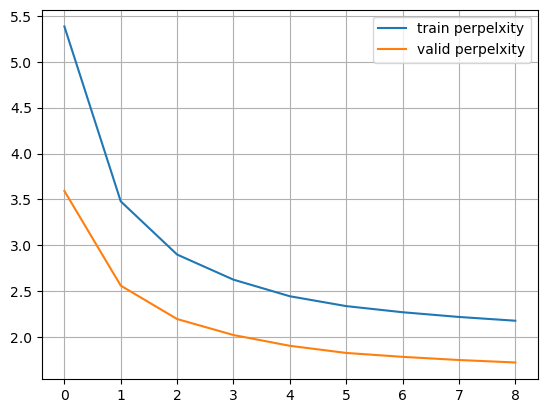

In [80]:
plt.plot(ppl_train_hist, label='train perpelxity')
plt.plot(ppl_valid_hist, label='valid perpelxity')
plt.legend()
plt.grid(True)

In [69]:
def generate(prompt, temp):
    model.eval()
    input_eval = [vocab[c] for c in prompt]
    with torch.no_grad():
        for i in range(1000):
            model.eval()
            predictions = model(torch.LongTensor(input_eval).unsqueeze(0).to(device))
            predictions = (predictions.squeeze() / temp)
            arg = torch.multinomial(F.softmax(predictions, dim=-1), 1)[-1]
            input_eval.append(arg)
    text = ''.join(itos[c] for c in input_eval)
    return text


In [70]:
generate('حافظ ای درنده خوی', temp=0.2).split('|')

['حافظ ای درنده خوی ما را بس',
 'به خاک پای تو ای سرو نازپرور من',
 'که در نظر و خط چون به مهر موی تو',
 'با درختيد خوش نباشد',
 'هر که شاهين کسی نصيحتگوی در ميان کار او',
 'با دل خونين لب خندان بياور همچو جام',
 'ن دل که به ياد ن که گر ست او سر نمی گيرد',
 'بدين شعر ترش روح که با دلدار بگشايد',
 'که ملغز تو علين قدا باشد',
 'هر کس نکند که اين عشق ز کاشانه تو داد',
 'باده با محتسب خون جگر دارد',
 'به خواب بی مثل و فتاب که يک سپند',
 'می بيخ زمانی گفتا حکايت اين جهان دارد',
 'چو دام عشق با دل خون گشت خواب کن',
 'ز ما چه ساقی می خورد لب جام است',
 'در مجلس ما عطر مياميز که ما را',
 'هرگز نبود غنچه گر و لود نيست که نيست',
 'بنده پير خراباتم که لطف اياد افتاد',
 'ببين که جام جهان بين که هزاران درد هان',
 'گفت ما کو تا براند زان تو دید',
 'در دل او در هوا چون شاخ و برگ',
 'شیخ کی بود کیمیای بی کران',
 'مس اگر از کیمیا قابل نبد',
 'کیمیا از مس هرگز مس نشد',
 'بود کس را دایه اسباب و ابد',
 'چون یکی حس از میانه درست',
 'صوفی ابله پای جغدانت تست',
 'چون نیاست ماه را با فرق پوش',
 'کی فروزد روح 